# Using MobileNet for our Actors Classifier


### Loading the MobileNet Model

In [1]:
ls /content/Actors.zip

/content/Actors.zip


In [2]:
!unzip Actors.zip

Archive:  Actors.zip
   creating: Actors/training_data/
   creating: Actors/training_data/Akshay_Kumar/
  inflating: Actors/training_data/Akshay_Kumar/a.jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (1).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (10).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (11).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (12).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (13).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (14).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (15).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (16).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (17).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (2).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (3).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (4).jpg  
  inflating: Actors/training_data/Akshay_

Freeze all layers except the top 4, as we'll only be training the top 4

In [3]:
from keras.applications import MobileNet

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

Using TensorFlow backend.


17227776/17225924 [==============================] - 1s 0us/step
0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False


### Let's make a function that returns our FC Head

In [0]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

### Let's add our FC Head back onto MobileNet

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# Set our class number to 3 (Young, Middle, Old)
num_classes = 4

FC_Head = lw(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

### Loading our Actors Dataset

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/Actors/training_data'
validation_data_dir = '/content/Actors/validation_data'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 199 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


### Training out Model
- Note we're using checkpointing and early stopping

In [10]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("actors_mobileNet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 199
nb_validation_samples = 20

# We only train 4 EPOCHS 
epochs = 3
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/3
12/12 [==============================] - 24s 2s/step - loss: 5.9638 - accuracy: 0.6287 - val_loss: 1.3313 - val_accuracy: 0.6500

Epoch 00001: val_loss improved from inf to 1.33134, saving model to actors_mobileNet.h5
Epoch 2/3
12/12 [==============================] - 23s 2s/step - loss: 0.8264 - accuracy: 0.7515 - val_loss: 1.6627 - val_accuracy: 0.5500

Epoch 00002: val_loss did not improve from 1.33134
Epoch 3/3
12/12 [==============================] - 22s 2s/step - loss: 0.3928 - accuracy: 0.8593 - val_loss: 0.2686 - val_accuracy: 0.9000

Epoch 00003: val_loss improved from 1.33134 to 0.26860, saving model to actors_mobileNet.h5


### Loading our classifer


In [0]:
from keras.models import load_model

classifier = load_model('actors_mobileNet.h5')

### Testing our classifer on some test images

Class - Amitabh_Bacchan


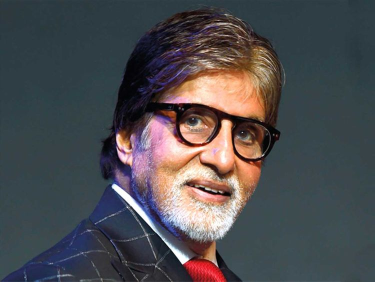

Class - Salman_Khan


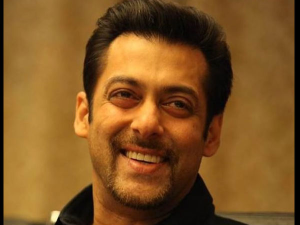

Class - Amitabh_Bacchan


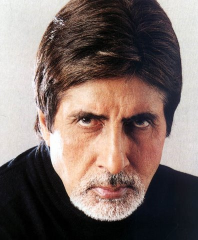

Class - Akshay_Kumar


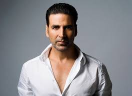

Class - Akshay_Kumar


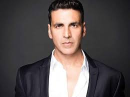

Class - Amitabh_Bacchan


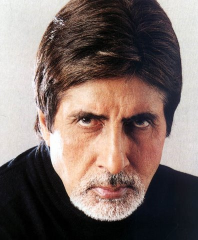

Class - Salman_Khan


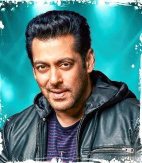

Class - Salman_Khan


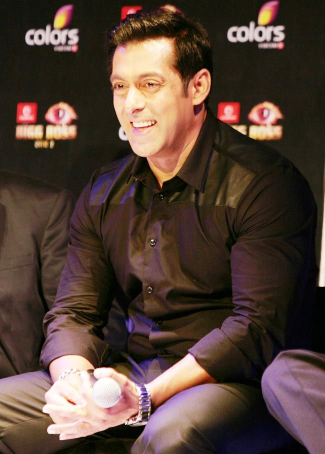

Class - Salman_Khan


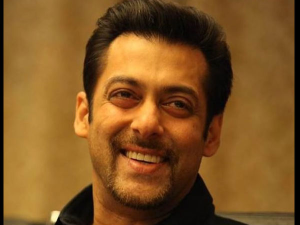

Class - Ranbir_Kapoor


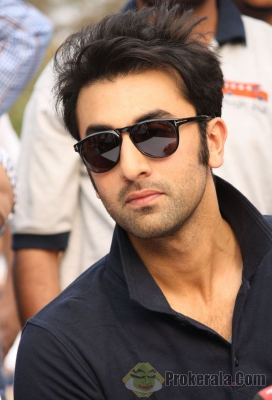

In [12]:
from IPython.display import clear_output
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from os import listdir
from os.path import isfile, join

Actors_dict = {"[0]": "Akshay_Kumar", 
                      "[1]": "Amitabh_Bacchan",
                      "[2]": "Ranbir_Kapoor",
                      "[3]": "Salman_Khan"}

Actors_dict_n = {"Akshay_Kumar": "Akshay_Kumar", 
                      "Amitabh_Bacchan": "Amitabh_Bacchan",
                      "Ranbir_Kapoor": "Ranbir_Kapoor",
                      "Salman_Khan": "Salman_Khan"}

def draw_test(name, pred, im):
    Actors = Actors_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, Actors, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + Actors_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("/content/Actors/validation_data/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    cv2_imshow(input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()